In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 
from scipy.optimize import minimize
import numpy as onp

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses
import make_plot

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)
reload(make_plot)

<module 'make_plot' from '/home/cholt/Python/torch_SSN/jax_caleb/make_plot.py'>

In [4]:
os.getpid()

41278

In [5]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [18]:
def ssn_PS(pos_params, contrasts):
    #unpack parameters
    params = sigmoid_params(pos_params)
    
    Jee = params[0] * np.pi * psi
    Jei = params[1] * np.pi * psi
    Jie = params[2] * np.pi * psi
    Jii = params[3] * np.pi * psi
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, f0, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, obs_f0, r_fp = ssn_PS(params, contrasts) 
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
    #half_width_rates = 20 # basin around acceptable rates 
    #lower_bound_rates = 0 # needs to be > 0, valley will start lower_bound, 5 is a nice value with kink_control = 5
    #upper_bound_rates = 80 # valley ends at upper_bound, keeps rates from blowing up
    
    lower_bound_rates = 5 * np.ones_like(r_fp)
    upper_bound_rates = np.array([[80*np.ones(len(contrasts))], [100*np.ones(len(contrasts))]])
    kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates
    
    prefact_rates = 1
    prefact_params = 10
    
    fs_loss_inds = np.arange(0 , len(fs))
    fs_loss_inds = np.array([freq for freq in fs_loss_inds if fs[freq] >20])#np.where(fs > 0, fs_loss_inds, )
#     fs_loss = fs[np.where(fs > 20)]
    
    spect_loss = losses.loss_spect_contrasts(fs[fs_loss_inds], np.real(spect[fs_loss_inds, :]))
    rates_loss = prefact_rates * losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control) #fourth arg is slope which is set to 1 normally
    param_loss = prefact_params * losses.loss_params(params)
#     peak_freq_loss = losses.loss_peak_freq(fs, obs_f0)
    
    if spect_loss/rates_loss < 1:
        print('rates loss is greater than spect loss')
#     print(spect_loss/rates_loss) 
    
    return spect_loss + param_loss + rates_loss # + peak_freq_loss #
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))

def sigmoid_params(pos_params):
    J_max = 3
    i2e_max = 2
    gE_max = 2
    gI_max = 1.5 #because I do not want gI_min = 0, so I will offset the sigmoid
    gI_min = 0.5
    NMDA_max = 1
    
    Jee = J_max * logistic_sig(pos_params[0])
    Jei = J_max * logistic_sig(pos_params[1])
    Jie = J_max * logistic_sig(pos_params[2])
    Jii = J_max * logistic_sig(pos_params[3])
    
    if len(pos_params) < 6:
        i2e = i2e_max * logistic_sig(pos_params[4])
        gE = 1
        gI = 1
        NMDAratio = 0.4
        
        params = onp.array([Jee, Jei, Jie, Jii, gE, gI, NMDAratio])
        
    else:
        i2e = 1
        gE = gE_max * logistic_sig(pos_params[4])
        gI = gI_max * logistic_sig(pos_params[5]) + gI_min
        NMDAratio = NMDA_max * logistic_sig(pos_params[6])
        
        params = np.array([Jee, Jei, Jie, Jii, gE, gI, NMDAratio])
    
    return params

def logistic_sig(x):
    return 1/(1 + np.exp(-x))



# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

run time: 1.3083081245422363


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

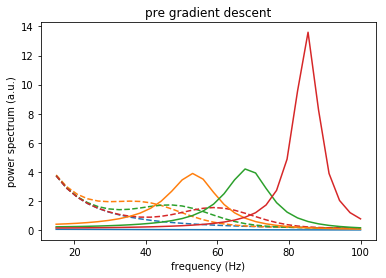

In [19]:
# params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5/3, 1.3/3, 2.4/3, 1.0/3, 1.0, 1.0, 0.6/3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2, 1.0, 0.3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, f0, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


rates loss is greater than spect loss
10.438241


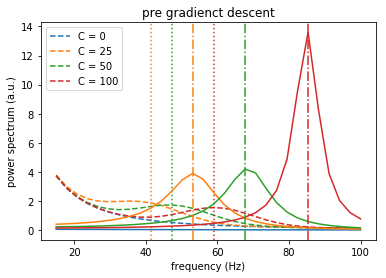

In [20]:
target_f0 = np.array(SSN_power_spec.find_peak_freq(fs, target_PS, len(test_contrasts)))
obs_f0 = np.array(SSN_power_spec.find_peak_freq(fs, spect, len(test_contrasts)))
color_order = ['tab:orange', 'tab:green', 'tab:red']
ind=0


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.legend(('C = 0', 'C = 25', 'C = 50', 'C = 100'))
for ff in target_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls=':')
    ind += 1
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ind=0
for ff in obs_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls='-.')
    ind += 1

ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

print(loss(params_init))

# Run Gradient Descent

In [33]:
import scipy
scipy.__version__

'1.3.1'

In [35]:
dloss = grad(loss)
# dloss = value_and_grad(loss)

def jac_dloss(params):
    gradient = onp.asarray(dloss(params))
    norm_grad.append(onp.linalg.norm(gradient))
    return gradient

def loss_hist(params):
    ll = onp.asarray(loss(params))
    loss_t.append(ll)
    return ll

# gd_iters = 1000
gd_iters = 10
eta = .001 #learning rate

params = params_init
loss_t = []
norm_grad = []

def c_back(xk):
    loss_t.append(xk.fun)
    norm_grad.append(np.norm(xk.jac))


t0 = time.time()

res = minimize(loss_hist, params, method='BFGS', jac=jac_dloss, options={'disp':True, 'maxiter':gd_iters})

# for ii in range(gd_iters):
#     if ii % 100 == 0:
#         print("G.D. step ", ii+1)
#     L, dL = dloss(params)
#     params = params - eta * dL #dloss(params)
#     loss_t.append(L)

params = res.x

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

rates loss is greater than spect loss


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss i

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
         Current function value: 3.923198
         Iterations: 6
         Function evaluations: 93
         Gradient evaluations: 87
10 GD steps took 475.7273042201996 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [ 0.03184696  0.8911756   1.40247176 -0.20699337  0.39016302  0.67002615
  0.40194102]


In [36]:
res

      fun: 3.9231977462768555
 hess_inv: array([[ 36.95262416,  23.99657217, -27.61550006,  -5.84645503,
         25.86347817,   4.85467407,  -7.93968704],
       [ 23.99657217,  15.86787507, -18.4156116 ,  -3.83460156,
         17.30590748,   3.14531674,  -5.33120167],
       [-27.61550006, -18.4156116 ,  22.21133802,   4.48760428,
        -19.86648902,  -3.72213715,   6.09900606],
       [ -5.84645503,  -3.83460156,   4.48760428,   0.95257393,
         -4.20798872,  -0.80334607,   1.29376943],
       [ 25.86347817,  17.30590748, -19.86648902,  -4.20798872,
         19.60391666,   3.49468438,  -5.71043849],
       [  4.85467407,   3.14531674,  -3.72213715,  -0.80334607,
          3.49468438,   0.74727995,  -1.07655102],
       [ -7.93968704,  -5.33120167,   6.09900606,   1.29376943,
         -5.71043849,  -1.07655102,   2.7524948 ]])
      jac: array([ 0.00099978,  0.22324719, -0.00236613, -0.37536275, -0.00810803,
       -0.3401872 ,  0.00567687], dtype=float32)
  message: 'Desired e

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

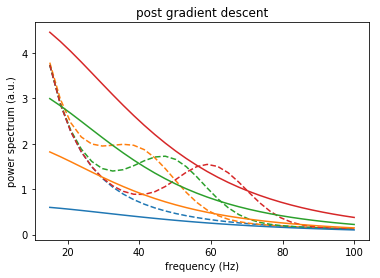

In [37]:
spect, fs, f0, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

Text(0.5,1,'I Rates')

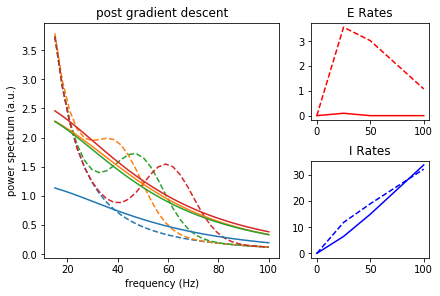

In [19]:
target_rates = losses.get_target_rates().T
obs_rates = r_fp.T

fig_combined = plt.figure(13, constrained_layout=True)
gs = gridspec.GridSpec(4,3, figure=fig_combined)

ax_spect = fig_combined.add_subplot(gs[:,0:2])
ax_spect.plot(fs, np.real(target_PS), "--")
#colrs = ax.get_color_cycle()
ax_spect.set_prop_cycle(None)
ax_spect.plot(fs, np.real(spect))
ax_spect.set_title('post gradient descent')
ax_spect.set_ylabel('power spectrum (a.u.)')
ax_spect.set_xlabel('frequency (Hz)')

ax_E = fig_combined.add_subplot(gs[0:2, 2])
ax_I = fig_combined.add_subplot(gs[2:, 2])

ax_E.plot(test_contrasts, target_rates[:, 0],  "r--")
ax_E.set_prop_cycle(None)
ax_E.plot(test_contrasts, obs_rates[:,0], 'r')
ax_E.set_title('E Rates')
# ax_E.set_xlabel('Contrasts')
# ax_E.set_ylabel('Firing Rates (Hz)')

ax_I.plot(test_contrasts, target_rates[:, 1],  "b--")
ax_I.set_prop_cycle(None)
ax_I.plot(test_contrasts, obs_rates[:,1], 'b')
ax_I.set_title('I Rates')
# ax_I.set_xlabel('Contrasts')
# ax_I.set_ylabel('Firing Rates (Hz)')

(2, 4)
(4,)
(4,)


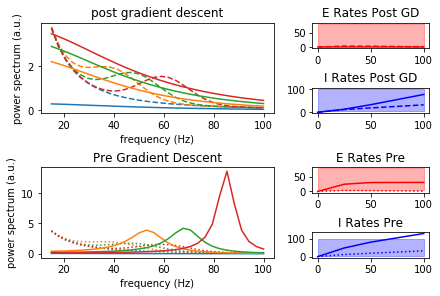

In [85]:
init_spect, _, _, init_r = ssn_PS(params_init, test_contrasts)
init_spect = np.real(init_spect/np.mean(np.real(init_spect)))
obs_spect, _, _, obs_r = ssn_PS(params, test_contrasts)
obs_spect = np.real(obs_spect/np.mean(np.real(obs_spect)))
target_rates = losses.get_target_rates()

lower_bound_rates = 5 * np.ones_like(r_fp)
upper_bound_rates = np.vstack((80*np.ones(len(test_contrasts)), 100*np.ones(len(test_contrasts))))
print(upper_bound_rates.shape)
make_plot.power_spect_rates_plot(fs, obs_spect, target_PS, test_contrasts, obs_rates, target_rates.T, init_spect, init_r.T, lower_bound_rates, upper_bound_rates)

In [69]:
# half_width_rates = 20 # basin around acceptable rates 
lower_bound_rates = 5
upper_bound_rates = 80
kink_control = 5 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates
    
    
print(losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control))
print(losses.loss_spect_contrasts(fs, np.real(spect)))
print(params)
print(r_fp)

1.3851999
5.025084
[ 0.22502153  1.9446467   1.2343359  -0.46964306  0.4977155   1.3269761
  0.38721907]
[[  0.        25.018759  30.890942  31.28898 ]
 [  0.        48.103912  80.48413  128.5325  ]]


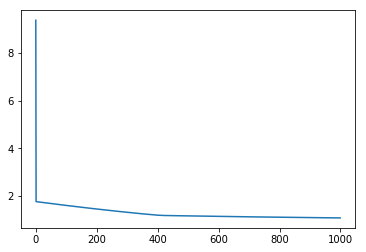

In [70]:
plt.plot(loss_t)

In [54]:
ideal_params = np.array([1.7, 1.525, 1.7, 0.5, 0.6])

print('Init Parameters ', params_init)
print('Found Parameters ', params)

print('Ground Truth Parameters ', ideal_params)

Init Parameters  [2.5 1.3 2.4 1.  1.  1.  0.6]
Found Parameters  [2.215861   1.1886845  2.4419672  1.1484814  0.63289255 0.7147526
 0.28001007]
Ground Truth Parameters  [1.7   1.525 1.7   0.5   0.6  ]


## If first loss didn't quite converge, run it again!

In [46]:
#dloss = grad(loss)
# dloss = value_and_grad(loss)

gd_iters = 1000
eta = eta #.005 #learning rate

# params = params_init
# loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201
G.D. step  301
G.D. step  401
G.D. step  501
G.D. step  601
G.D. step  701
G.D. step  801
G.D. step  901
1000 GD steps took 4837.4157383441925 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [2.4374564 1.222656  2.4180098 1.1174014 0.9356065 1.0382547 1.0001299]


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'G.D. Step')

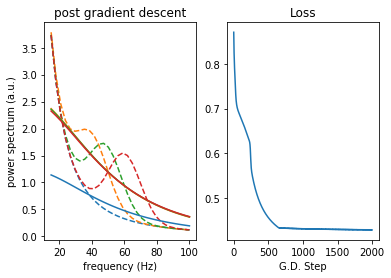

In [47]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, [ax, ax2] = plt.subplots(1,2)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

ax2.plot(loss_t[:])
ax2.set_title('Loss')
ax2.set_xlabel('G.D. Step')

## Save data 

In [19]:
import scipy.io as sio

data = {
    'params_final':params,
    'params_init':params_init,
    'spect_final':obs_spect,#spect,
    'rfp_final':obs_rates, #r_fp,
    'loss_t':loss_t,
    'ideal_fname':'standJ19-09-20-BestSpect.mat'
}


sio.savemat("LzianTargets_BetterFit_2019-10-24.mat", data)

# Easy Running Form

In [7]:
import ssn_gamma_2D
import bfgs_ssn_gamma_2D
import jax.numpy as np
import matplotlib.pyplot as plt
from util import sigmoid_params

from importlib import reload
reload(ssn_gamma_2D)
reload(bfgs_ssn_gamma_2D)

<module 'bfgs_ssn_gamma_2D' from '/home/cholt/Python/torch_SSN/jax_caleb/bfgs_ssn_gamma_2D.py'>

In [8]:
# eta = 0.0001 #learning rate
eta = 0.001 #learning rate

# params_init = np.array([2.5/3, 1.3/3, 2.4/3, 1.0/3, 1.0, 1.0, 0.6/3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
# params_init = np.array([1.6094377 , -0.26826397,  1.3862944 , -0.6931472, 1.0, 1.0, 0.6]) # original GD that converged to ground_truth, ready for sigmoids in J
#params_init = np.array([2.5, 1.3, 2.4, 1.0, 1.0, 1.0, 0.6]) #ground truth init parameters == No sigmoid

#params_init = np.array([1.6094377 , -0.26826397,  1.3862944 , -0.6931472, 1.0, 1.0, 0.6, np.ravel(obs_rates)]) # now with final rates of prev time step!
params_init= np.array([ 1.60943794, -0.26826397,  1.38629436, -0.69314718, -0., -0.69314718,  0.40546507])
psi = 0.774 * np.pi

# params_init = np.array([1.95/psi, 1.25/psi, 2.45/psi, 1.5/psi, 1.25])

obs_spect, obs_rates, params, loss_t = ssn_gamma_2D.full_gd_gamma(params_init, eta, fname='ground_truth_Reproduction-take13.pdf')

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201
G.D. step  301
G.D. step  401
G.D. step  501
G.D. step  601
G.D. step  701
G.D. step  801
G.D. step  901
1000 GD steps took 3909.1623849868774 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [ 1.7111279  -0.4166393   1.2581985  -0.7622177  -0.13154535 -0.7177299
  0.0063892 ]


ValueError: too many values to unpack (expected 4)

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)



 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = Traced<ConcreteArray(nan)>with<JVPTrace(level=2/0)>,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)



 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = Traced<ConcreteArray(nan)>with<JVPTrace(level=2/0)>,   xtol=1e-06.

Did not reach fixed point.


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)



 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)
/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)
/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)
/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


         Current function value: 0.021705
         Iterations: 116
         Function evaluations: 274
         Gradient evaluations: 255
1000 GD steps took 1566.296548128128 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [2.9917951e+00 2.8713496e+00 2.9994941e+00 2.7097173e+00 5.8455294e-01
 6.1449593e-01 1.8440702e-04]


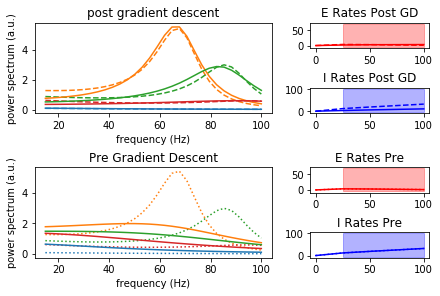

In [5]:
params_init= np.array([ 1.60943794, -0.26826397,  1.38629436, -0.69314718, -0., -0.69314718,  0.40546507])

obs_spect, obs_rates, params, loss_t = bfgs_ssn_gamma_2D.bfgs_gamma(params_init, fname='BFGS_Test.pdf')

Text(0,0.5,'Loss')

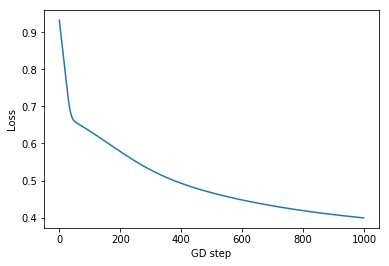

In [3]:
plt.plot(loss_t)
plt.xlabel('GD step')
plt.ylabel('Loss')

In [12]:
print(obs_rates)

print(np.reshape(np.ravel(obs_rates), (2,4)))

[[ 0.        11.886201   7.6693215  3.1348078]
 [ 0.        22.485413  24.79634   35.148746 ]]
[[ 0.        11.886201   7.6693215  3.1348078]
 [ 0.        22.485413  24.79634   35.148746 ]]


In [12]:
from jax import grad

In [4]:
print(params[0:4]*psi, params[4])
print(sigmoid_params(params))

[ 4.1607614 -1.0130976  3.0594292 -1.8534017] -0.13154618
[2.5409467  1.1919634  2.336148   0.9544953  0.9343216  0.99183947
 0.50159717]


In [ ]:
obs_spect, obs_rates, params, loss_t = ssn_gamma_2D.full_gd_gamma(params, eta/2, fname='ground_truth_Reproduction-take11-secondRun.pdf')

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201


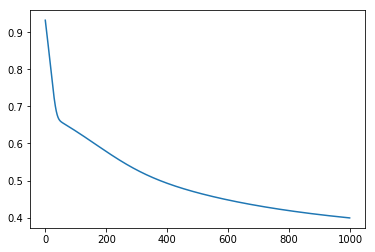

In [5]:
plt.plot(loss_t)

In [3]:
eta = 0.0001 #learning rate
params_init = np.array([2.5/3, 1.3/3, 2.4/3, 1.0/3, 1.0, 1.0, 0.6/3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]

#pr = %prun -r ssn_gamma_2D.full_gd_gamma(params_init, eta, fname='profile_run.pdf')

In [4]:
# # from pstats import SortKey
# pr.sort_stats('cumulative')
# pr.print_stats()

In [6]:
%load_ext line_profiler

G.D. step  1
rates loss is greater than spect loss


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
3 GD steps took 21.687036752700806 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [0.7828234  0.5698878  0.8356505  0.22397675 0.9559087  1.0418252
 0.21583487]


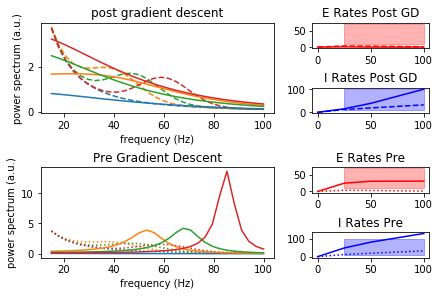

Timer unit: 1e-06 s

Total time: 26.5674 s
File: /home/cholt/Python/torch_SSN/jax_caleb/ssn_gamma_2D.py
Function: full_gd_gamma at line 42

Line #      Hits         Time  Per Hit   % Time  Line Contents
    42                                           def full_gd_gamma(params_init, eta, fname = 'new_fig.pdf'):
    43                                           #     #the constant (non-optimized) parameters:
    44                                           
    45                                           #     #fixed point algorithm:
    46                                           #     dt = 1
    47                                           #     xtol = 1e-6
    48                                           #     Tmax = 500
    49                                           
    50                                           #     #power spectrum resolution and range
    51                                           #     fnums = 30
    52                                           #     freq

In [8]:
%lprun -f ssn_gamma_2D.full_gd_gamma ssn_gamma_2D.full_gd_gamma(params_init, eta, fname='profile_run.pdf')

G.D. step  1
rates loss is greater than spect loss


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
3 GD steps took 21.792192935943604 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [0.7828234  0.5698878  0.8356505  0.22397675 0.9559087  1.0418252
 0.21583487]


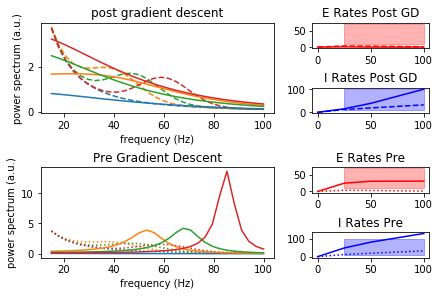

Timer unit: 1e-06 s

Total time: 21.4935 s
File: /home/cholt/Python/torch_SSN/jax_caleb/ssn_gamma_2D.py
Function: ssn_PS at line 140

Line #      Hits         Time  Per Hit   % Time  Line Contents
   140                                           def ssn_PS(params, contrasts):
   141                                               #unpack parameters
   142         5      32502.0   6500.4      0.2      Jee = params[0]
   143         5      14140.0   2828.0      0.1      Jei = params[1]
   144         5      13875.0   2775.0      0.1      Jie = params[2]
   145         5      13558.0   2711.6      0.1      Jii = params[3]
   146                                               
   147         5        128.0     25.6      0.0      if len(params) < 6:
   148                                                   i2e = params[4]
   149                                                   gE = 1
   150                                                   gI = 1
   151                                         

In [12]:
%lprun -f ssn_gamma_2D.ssn_PS ssn_gamma_2D.full_gd_gamma(params_init, eta, fname='profile_run.pdf')

G.D. step  1
rates loss is greater than spect loss


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
3 GD steps took 21.903367519378662 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [0.7828234  0.5698878  0.8356505  0.22397675 0.9559087  1.0418252
 0.21583487]


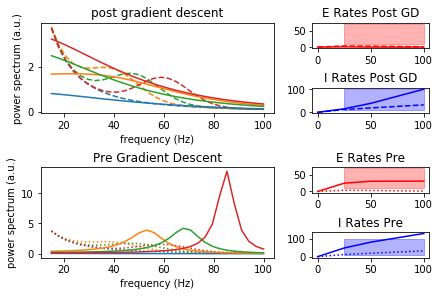

Timer unit: 1e-06 s

Total time: 17.2336 s
File: /home/cholt/Python/torch_SSN/jax_caleb/util.py
Function: Euler2fixedpt at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def Euler2fixedpt(dxdt, x_initial, Tmax, dt, xtol=1e-5, xmin=1e-0, PLOT=False, inds=None):
     5                                               """
     6                                               Finds the fixed point of the D-dim ODE set dx/dt = dxdt(x), using the
     7                                               Euler update with sufficiently large dt (to gain in computational time).
     8                                               Checks for convergence to stop the updates early.
     9                                           
    10                                               IN:
    11                                               dxdt = a function handle giving the right hand side function of dynamical system
    12          

In [15]:
%lprun -f ssn_gamma_2D.SSN_classes.Euler2fixedpt ssn_gamma_2D.full_gd_gamma(params_init, eta, fname='profile_run.pdf')

In [1]:
import numpy as np
import SSN_classes
import SSN_power_spec

%load_ext line_profiler

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

contrasts = np.array([0, 25, 50, 100])
cons = len(contrasts)
lower_bound_rates = 10 * np.ones([2, cons-1])
upper_bound_rates = np.vstack((70*np.ones(cons-1), 100*np.ones(cons-1)))
kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates    

def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)
    
    psi = 0.774
    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, f0, r_fp

In [3]:
eta = 0.0001 #learning rate
params_init = np.array([2.5/3, 1.3/3, 2.4/3, 1.0/3, 1.0, 1.0, 0.6/3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
contrasts = np.array([0, 25, 50, 100])

%lprun -f SSN_classes.Euler2fixedpt ssn_PS(params_init, contrasts)

Timer unit: 1e-06 s

Total time: 0.012297 s
File: /home/cholt/Python/torch_SSN/jax_caleb/util.py
Function: Euler2fixedpt at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def Euler2fixedpt(dxdt, x_initial, Tmax, dt, xtol=1e-5, xmin=1e-0, PLOT=False, inds=None):
     5                                               """
     6                                               Finds the fixed point of the D-dim ODE set dx/dt = dxdt(x), using the
     7                                               Euler update with sufficiently large dt (to gain in computational time).
     8                                               Checks for convergence to stop the updates early.
     9                                           
    10                                               IN:
    11                                               dxdt = a function handle giving the right hand side function of dynamical system
    12         

In [8]:
import scipy.io as sio

In [9]:
bb = sio.loadmat('ground_truth_Reproduction-take7.mat')

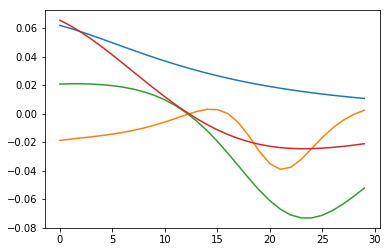

In [14]:
plt.plot(bb['obs_spect'] - obs_spect)

Text(0.5,0,'frequency (Hz)')

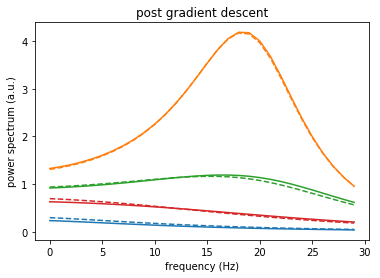

In [17]:
fig2, ax = plt.subplots(1,1)
ax.plot(bb['obs_spect'], "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(obs_spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [1]:
import scipy.io as sio
from util import sigmoid_params
from util import find_params_to_sigmoid
from bfgs_ssn_gamma_2D import ssn_PS
import jax.numpy as np
import matplotlib.pyplot as plt

/home/cholt/miniconda3/envs/juCpu/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
aa = sio.loadmat('Two_neuron_Results/Gaussian_Slower_learning_rate.mat')
aa['params']

array([[0.7772902 , 0.5143555 , 0.7756234 , 0.43755746, 0.89437723,
        0.92515683, 0.2000281 ]], dtype=float32)

In [3]:
sigmoid_params(aa['params'][0], MULTI=False)

DeviceArray([2.0552876, 1.8774809, 2.0542083, 1.8230306, 2.2445614,
             2.3542602, 0.549841 ], dtype=float32)

In [4]:
contrasts = np.array([0, 25, 50, 100])  
spect, fs, f0, r_fp, CONVG = ssn_PS(find_params_to_sigmoid(aa['params'][0], MULTI=False), contrasts)

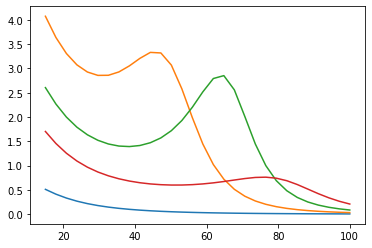

In [5]:
plt.plot(fs, np.real(spect)/np.mean(np.real(spect)))

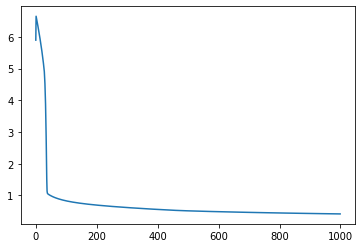

In [30]:
plt.plot(aa['loss_t'][0])

In [6]:
from jax import random

In [7]:
key = random.PRNGKey(17)
params = random.uniform(key, shape=(7,))

print(params[4:])

_, subkey = random.split(key)
while params[0]*params[3] > params[1]*params[2]:
    print('yes')
    params[:4] = random.uniform(subkey, shape=(4,))
print(params)

[0.12775385 0.8074789  0.16477203]
yes


TypeError: '<class 'jax.interpreters.xla.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?